# Music generation with Auto-Encoder

Build a 2 layers auto-encoder with TensorFlow to generate music with a lower latent space and construct them.

- Author: Antoine Drabble
- Project: https://github.com/drabble/???

Sources : 

- https://keras.io/examples/generative/vae/
- https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


TODO :

- Try to replace the velocity of a note with a duration instead (so we have long notes)
- Is it possible to have duration as well as velocity, should this be a second network or lstm somehow?
- Put back the csv generation in here
- Push on github
- Clean up the code a bit more
- Add the decode part so we can generate from a z distribution

## Imports

In [1]:
# Midi and audio
import midi #pip install git+https://github.com/vishnubob/python-midi@feature/python3
from music21 import converter

# Machine learning
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# Plots
import matplotlib.pyplot as plt

# Files
from pathlib import Path
import os

In [2]:
WIDTH = 128 # Width of the track
HEIGHT = 30 # Height of track (number of notes/octaves)
OFFSET = 60 # Starting note from the lowest midi note
INTERVAL = 128 # Minimum number of ticks between two notes

BATCH_SIZE = 50 # Batch size
LATENT_SPACE = 12 # Size of latent layer mu and sigma
EPOCHS = 200

## Read dataset

In [3]:
result = list(Path("./vg_piano").rglob("*.[mM][iI][dD]"))
dataset = []
array = []
for x in range(len(result)):
    try:
        array = np.zeros(WIDTH * HEIGHT)
        pattern = midi.read_midifile(result[x].as_posix())
        #print(result[x])
        for i in range(len(pattern)): # For each track
            tickCount = 0
            for j in range(len(pattern[i])): # For each event in track
                if type(pattern[i][j]) is midi.NoteOnEvent or type(pattern[i][j]) is midi.NoteOffEvent:
                    tickCount += pattern[i][j].tick
                if math.floor(tickCount / INTERVAL) >= WIDTH:
                    break
                if type(pattern[i][j]) is midi.NoteOnEvent and pattern[i][j].tick >= 0 and pattern[i][j].channel != 10 and pattern[i][j].data[0] < HEIGHT + OFFSET and pattern[i][j].data[0] >= OFFSET:
                    array[(pattern[i][j].data[0] - OFFSET) * WIDTH + math.floor(tickCount / INTERVAL)] = min(pattern[i][j].data[1] / 100, 1)
        dataset.append(array)
    except Exception as e:
        print("ERROR: ", e)
print("DONE ", len(result), " midi files")
np.savetxt("dataset2.csv", np.array(dataset), fmt='%10.2f', delimiter=",")

DONE  730  midi files


In [4]:
print(midi.read_midifile(result[2].as_posix()))

midi.Pattern(format=1, resolution=960, tracks=\
[midi.Track(\
  [midi.SequencerSpecificEvent(tick=0, data=[5, 15, 18, 0, 0, 107, 127, 0, 7, 1]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 28, 50, 48, 48, 55, 46, 49, 48, 46, 48, 50]),
   midi.KeySignatureEvent(tick=0, data=[0, 0]),
   midi.TrackNameEvent(tick=0, text='Track 0', data=[84, 114, 97, 99, 107, 32, 48]),
   midi.SetTempoEvent(tick=0, data=[6, 26, 128]),
   midi.EndOfTrackEvent(tick=0, data=[])]),
 midi.Track(\
  [midi.SequencerSpecificEvent(tick=0, data=[5, 15, 9, 0, 64]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 6, 71, 101, 110, 101, 114, 97, 108, 32, 77, 73, 68, 73]),
   midi.TrackNameEvent(tick=0, text='Right Hand', data=[82, 105, 103, 104, 116, 32, 72, 97, 110, 100]),
   midi.SequencerSpecificEvent(tick=0, data=[5, 15, 16, 0]),
   midi.ProgramChangeEvent(tick=0, channel=0, data=[0]),
   midi.ChannelPrefixEvent(tick=0, data=[0]),
   midi.NoteOnEvent(tick=7680, channel=0, data=[74, 89]),
   midi.NoteOffE

### Read some midi tracks from the dataset

In [5]:
def generateTrack(data):
    # Instantiate a MIDI Pattern (contains a list of tracks)
    p = midi.Pattern()
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    p.append(track)
    # Instantiate a MIDI note on event, append it to the track
    tickCount = 0
    track.append(midi.NoteOnEvent(tick=0, velocity=100, pitch=60))
    track.append(midi.NoteOnEvent(tick=100, velocity=100, pitch=60))

    for x in range(WIDTH):
        for y in range(HEIGHT):
            if data[y * WIDTH + x] > 0.2:
                track.append(midi.NoteOnEvent(tick=tickCount, velocity=int(data[y * WIDTH + x] * 100), pitch=OFFSET + y))
                tickCount = 0
        tickCount += INTERVAL
    # Add the end of track event, append it to the track
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    return p

def generateTrackImage(data):
        canvas_orig = np.empty((HEIGHT, WIDTH))
        for j in range(WIDTH * HEIGHT):
            # Draw the midi notes
            canvas_orig[int(j / WIDTH), j % WIDTH] = data[j]
        print("Original Images")   
        plt.figure(figsize=(5,20))  
        plt.imshow(canvas_orig, origin="upper", cmap="gray")
        plt.show()

vg_piano/GameCornerRag.mid
Original Images


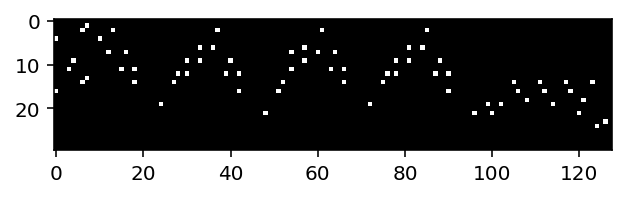

vg_piano/TheSims_TheNeighborhood_Piano.mid
Original Images


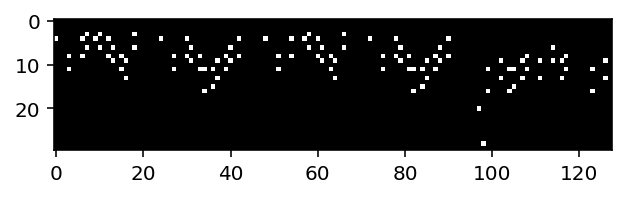

vg_piano/chocomountainpiano.mid
Original Images


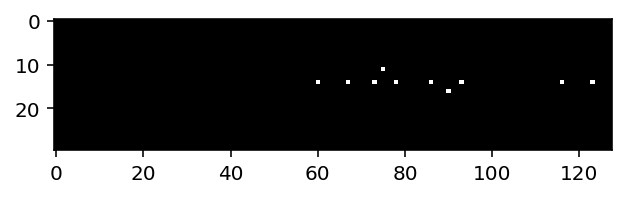

vg_piano/TjsS2OP.mid
Original Images


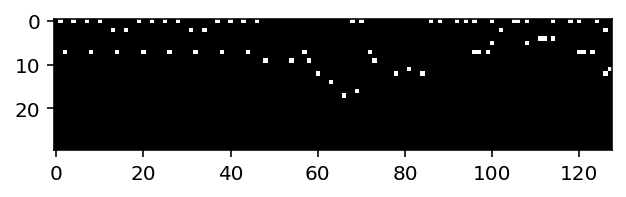

vg_piano/SaveCottagespiano.mid
Original Images


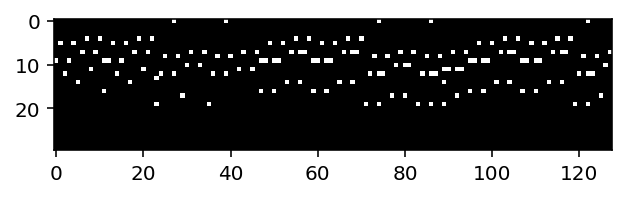

vg_piano/rozen-maiden-kodoku-na-kokoro.mid
Original Images


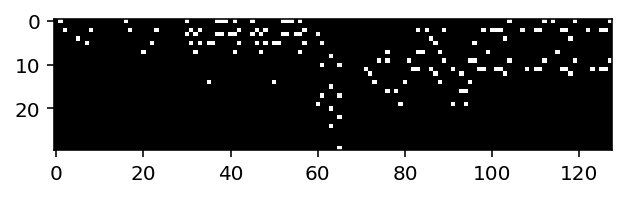

vg_piano/Mario_3.mid
Original Images


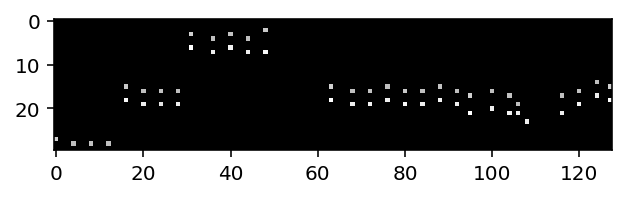

vg_piano/DemonCastlePinnacle.mid
Original Images


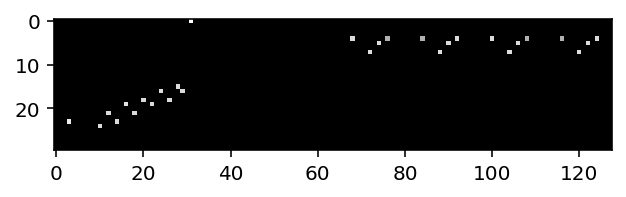

vg_piano/Windfall_Island.mid
Original Images


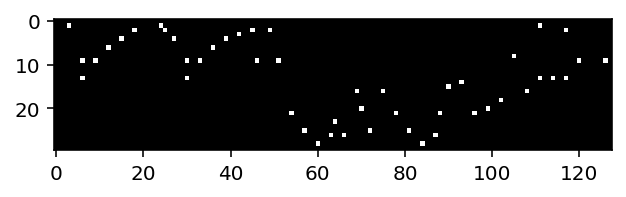

vg_piano/Route_12.mid
Original Images


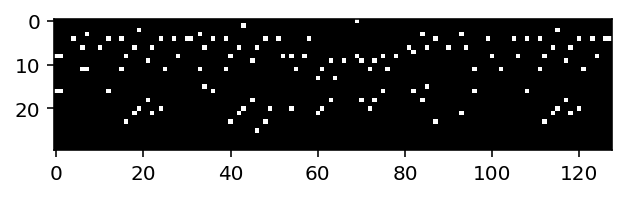

midi.Pattern(format=1, resolution=220, tracks=\
[midi.Track(\
  [midi.NoteOnEvent(tick=0, channel=0, data=[60, 100]),
   midi.NoteOnEvent(tick=100, channel=0, data=[60, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[64, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[76, 100]),
   midi.NoteOnEvent(tick=384, channel=0, data=[71, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[69, 100]),
   midi.NoteOnEvent(tick=256, channel=0, data=[62, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[74, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[61, 100]),
   midi.NoteOnEvent(tick=0, channel=0, data=[73, 100]),
   midi.NoteOnEvent(tick=384, channel=0, data=[64, 100]),
   midi.NoteOnEvent(tick=256, channel=0, data=[67, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[62, 100]),
   midi.NoteOnEvent(tick=256, channel=0, data=[71, 100]),
   midi.NoteOnEvent(tick=128, channel=0, data=[67, 100]),
   midi.NoteOnEvent(tick=256, channel=0, data=[71, 100]),
   midi.NoteOnEvent(

In [6]:
for i in range(10):
    print(result[i].as_posix())
    
    pattern = generateTrack(dataset[i]);
    
    # Save the pattern to disk
    midi.write_midifile(str(i) + ".mid", pattern)

    generateTrackImage(dataset[i])
    
    s = converter.parse(result[i].as_posix())
    s.show('midi')
    s = converter.parse(str(i) + '.mid')
    s.show('midi')
    
print(midi.read_midifile(str(0)+'.mid'))

## Load dataset from csv

In [7]:
train_dataset_fp = np.genfromtxt(r"dataset2.csv",delimiter=",")

x_train = train_dataset_fp[0:500].astype('float32')
x_test = train_dataset_fp[500:600].astype('float32')

## Configure neural network

### Encoder

In [8]:
# Q(z|X) -- encoder
inputs = keras.layers.Input(shape=x_train[0].shape)
encoder_hidden = keras.layers.Dense(512, activation='relu')(inputs)
z_mean = keras.layers.Dense(LATENT_SPACE, activation='linear')(encoder_hidden)
z_log_var = keras.layers.Dense(LATENT_SPACE, activation='linear')(encoder_hidden)


### Latent space

In [9]:
def sample_z(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)), mean=0., stddev=1.0)
    return z_mean + keras.backend.exp(z_log_var / 2) * eps

# Sample z ~ Q(z|X)
z = keras.layers.Lambda(sample_z)([z_mean, z_log_var])

### Decoder

In [10]:
# P(X|z) -- decoder
decoder_hidden = keras.layers.Dense(512, activation='relu')(z)
outputs = keras.layers.Dense(x_train[0].shape[0], activation='sigmoid')(decoder_hidden)

print(decoder_hidden)
print(outputs)

Tensor("dense_3/Identity:0", shape=(None, 512), dtype=float32)
Tensor("dense_4/Identity:0", shape=(None, 3840), dtype=float32)


### Complete VAE

In [11]:
# Overall VAE model, for reconstruction and training
vae = keras.Model(inputs, outputs)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3840)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1966592     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           6156        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           6156        dense[0][0]                      
______________________________________________________________________________________________

In [12]:
# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = keras.Model(inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3840)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1966592     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           6156        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           6156        dense[0][0]                      
Total params: 1,978,904
Trainable params: 1,978,904
Non-trainable params: 0
________________

In [13]:
# Generator model, generate new data given latent variable z
#d_in = keras.layers.Input(shape=(LATENT_SPACE,))
#decoder = keras.Model(d_in, outputs)
#decoder.summary()

### Loss function

In [14]:
def vae_loss(x, x_decoded_mean):
    z_mean, z_log_var = encoder(x)
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(x, x_decoded_mean)
    )
    reconstruction_loss *= x_train[0].shape[0]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss)
    return reconstruction_loss + kl_loss

## Train VAE

In [15]:
print(x_train[0])
print(x_test[0])

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [16]:
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,clipnorm=1), 
    loss=vae_loss, 
    metrics=['accuracy'])
history = vae.fit(
    x_train, 
    x_train, 
    shuffle=True,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    epochs=EPOCHS)
print(history)

Epoch 1/200
10/10 [==============================] - 1s 51ms/step - loss: 1052.1265 - accuracy: 0.0020 - val_loss: 435.8588 - val_accuracy: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 33ms/step - loss: 1058.2866 - accuracy: 0.0060 - val_loss: 410.9914 - val_accuracy: 0.0100
Epoch 3/200
10/10 [==============================] - 0s 36ms/step - loss: 437.2198 - accuracy: 0.0040 - val_loss: 383.4177 - val_accuracy: 0.0000e+00
Epoch 4/200
10/10 [==============================] - 0s 35ms/step - loss: 411.9711 - accuracy: 0.0000e+00 - val_loss: 362.9391 - val_accuracy: 0.0000e+00
Epoch 5/200
10/10 [==============================] - 0s 35ms/step - loss: 388.6461 - accuracy: 0.0000e+00 - val_loss: 353.0903 - val_accuracy: 0.0000e+00
Epoch 6/200
10/10 [==============================] - 0s 35ms/step - loss: 347.9887 - accuracy: 0.0020 - val_loss: 348.4636 - val_accuracy: 0.0100
Epoch 7/200
10/10 [==============================] - 0s 34ms/step - loss: 328.5666 - accuracy: 0.0

10/10 [==============================] - 0s 31ms/step - loss: 41.5879 - accuracy: 0.0460 - val_loss: 626.5601 - val_accuracy: 0.0000e+00
Epoch 57/200
10/10 [==============================] - 0s 31ms/step - loss: 43.5955 - accuracy: 0.0320 - val_loss: 565.3821 - val_accuracy: 0.0100
Epoch 58/200
10/10 [==============================] - 0s 31ms/step - loss: 43.3922 - accuracy: 0.0380 - val_loss: 566.8234 - val_accuracy: 0.0100
Epoch 59/200
10/10 [==============================] - 0s 30ms/step - loss: 40.1289 - accuracy: 0.0380 - val_loss: 571.6072 - val_accuracy: 0.0100
Epoch 60/200
10/10 [==============================] - 0s 33ms/step - loss: 41.0556 - accuracy: 0.0400 - val_loss: 560.1255 - val_accuracy: 0.0100
Epoch 61/200
10/10 [==============================] - 0s 31ms/step - loss: 60.9732 - accuracy: 0.0360 - val_loss: 591.7804 - val_accuracy: 0.0100
Epoch 62/200
10/10 [==============================] - 0s 31ms/step - loss: 47.7235 - accuracy: 0.0380 - val_loss: 642.1917 - val_accu

Epoch 112/200
10/10 [==============================] - 0s 40ms/step - loss: 44.6009 - accuracy: 0.0360 - val_loss: 551.7612 - val_accuracy: 0.0100
Epoch 113/200
10/10 [==============================] - 0s 40ms/step - loss: 41.4387 - accuracy: 0.0380 - val_loss: 618.8657 - val_accuracy: 0.0100
Epoch 114/200
10/10 [==============================] - 0s 47ms/step - loss: 78.3395 - accuracy: 0.0460 - val_loss: 497.8160 - val_accuracy: 0.0200
Epoch 115/200
10/10 [==============================] - 0s 33ms/step - loss: 38.8082 - accuracy: 0.0500 - val_loss: 537.7187 - val_accuracy: 0.0100
Epoch 116/200
10/10 [==============================] - 0s 33ms/step - loss: 40.9944 - accuracy: 0.0320 - val_loss: 611.7303 - val_accuracy: 0.0200
Epoch 117/200
10/10 [==============================] - 0s 31ms/step - loss: 50.1993 - accuracy: 0.0440 - val_loss: 611.5140 - val_accuracy: 0.0100
Epoch 118/200
10/10 [==============================] - 0s 32ms/step - loss: 40.7154 - accuracy: 0.0320 - val_loss: 555

10/10 [==============================] - 1s 65ms/step - loss: 33.1142 - accuracy: 0.0380 - val_loss: 637.5818 - val_accuracy: 0.0000e+00
Epoch 168/200
10/10 [==============================] - 1s 50ms/step - loss: 30.6116 - accuracy: 0.0320 - val_loss: 630.1052 - val_accuracy: 0.0100
Epoch 169/200
10/10 [==============================] - 1s 53ms/step - loss: 32.4074 - accuracy: 0.0540 - val_loss: 647.5580 - val_accuracy: 0.0000e+00
Epoch 170/200
10/10 [==============================] - 0s 48ms/step - loss: 31.1736 - accuracy: 0.0540 - val_loss: 606.7227 - val_accuracy: 0.0000e+00
Epoch 171/200
10/10 [==============================] - 1s 55ms/step - loss: 36.7653 - accuracy: 0.0580 - val_loss: 696.8748 - val_accuracy: 0.0100
Epoch 172/200
10/10 [==============================] - 0s 39ms/step - loss: 31.5275 - accuracy: 0.0520 - val_loss: 624.6031 - val_accuracy: 0.0000e+00
Epoch 173/200
10/10 [==============================] - 0s 39ms/step - loss: 70.0196 - accuracy: 0.0500 - val_loss: 5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


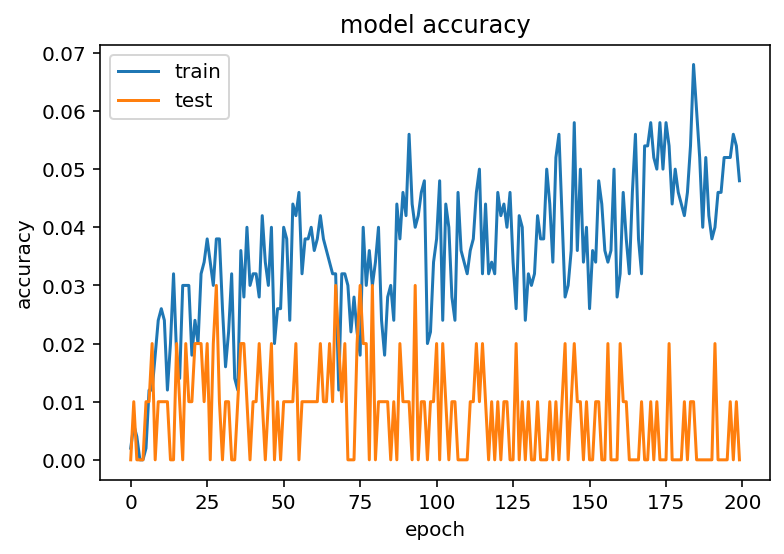

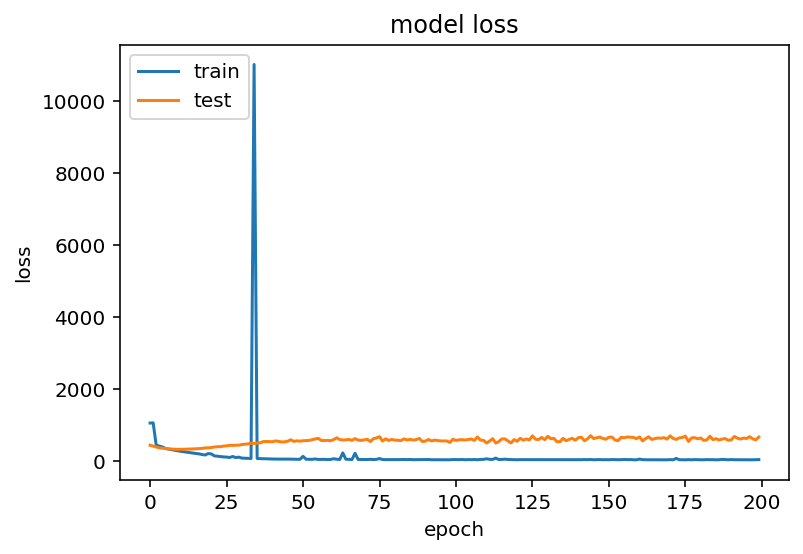

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

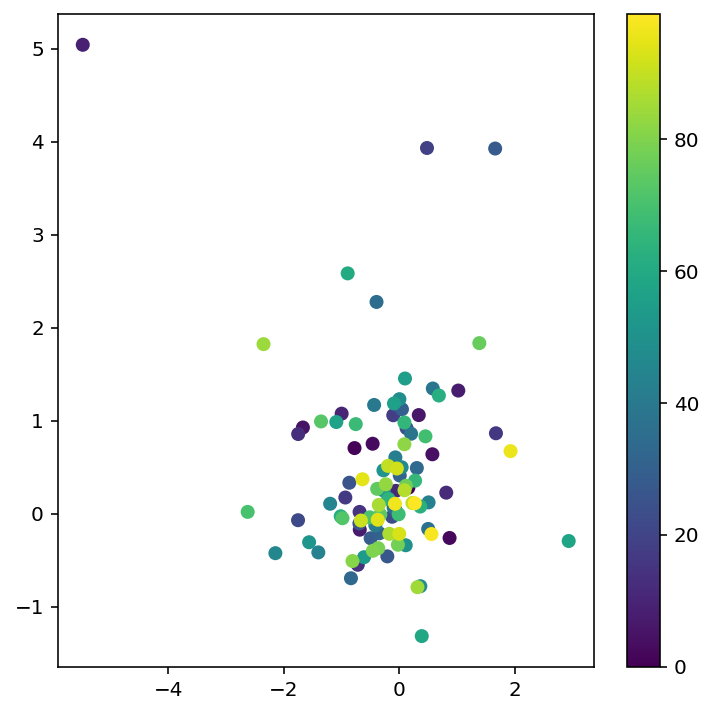

In [18]:
# build a model to project inputs on the latent space
# This is pretty much useless, but we can see that the latent variables follow more or less the norma distribution
encoder = keras.Model(inputs, z_mean)# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=BATCH_SIZE)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=range(BATCH_SIZE*2))
plt.colorbar()
plt.show()

## Evaluate trained model

In [19]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = vae.evaluate(x_test, x_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 4ms/step - loss: 657.7969 - accuracy: 0.0000e+00
test loss, test acc: [657.796875, 0.0]


# Generate predictions (probabilities -- the output of the last layer)

Generate predictions for 3 samples
(100, 3840)
predictions shape: (100, 3840)
Original
x_test_0.mid


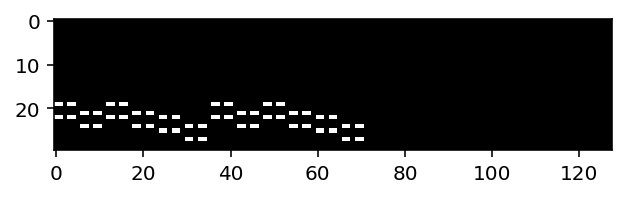

Reproduction


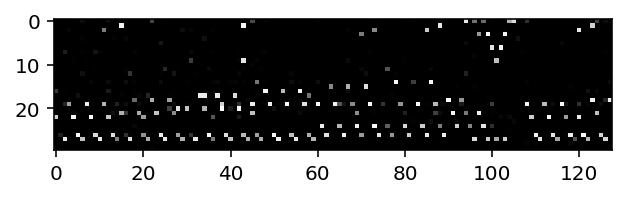

prediction_0.mid


Original
x_test_1.mid


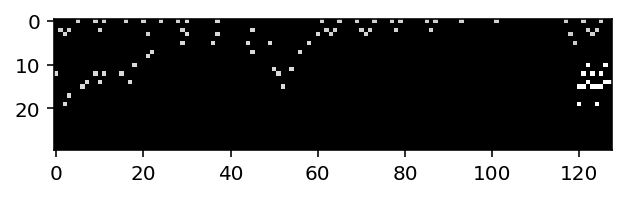

Reproduction


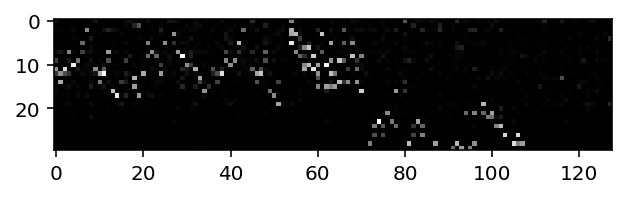

prediction_1.mid


Original
x_test_2.mid


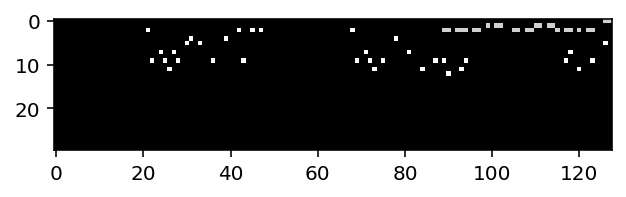

Reproduction


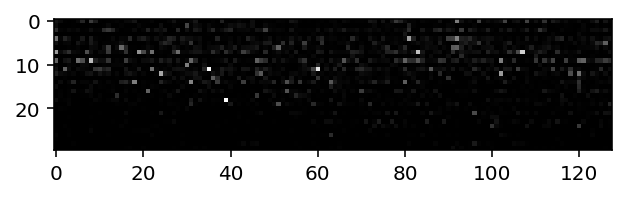

prediction_2.mid


Original
x_test_3.mid


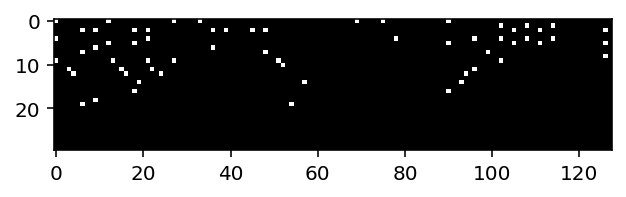

Reproduction


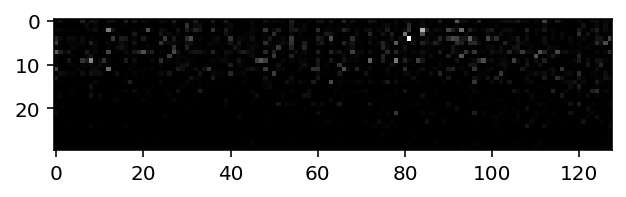

prediction_3.mid


Original
x_test_4.mid


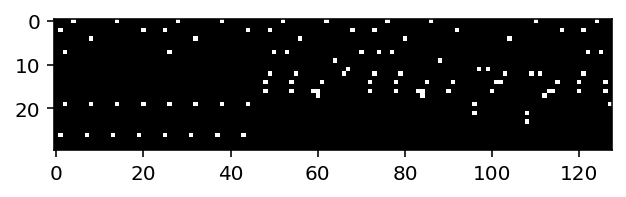

Reproduction


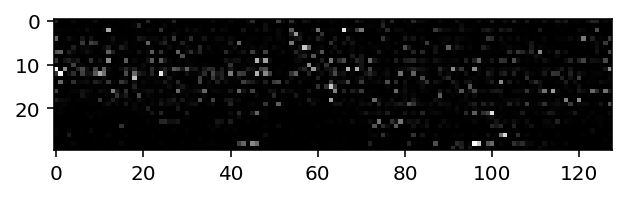

prediction_4.mid


Original
x_test_5.mid


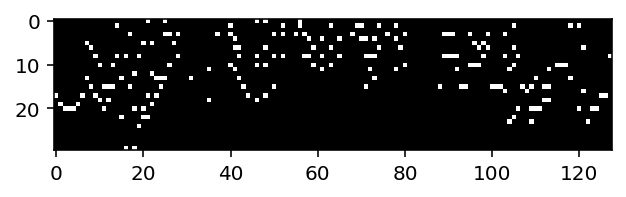

Reproduction


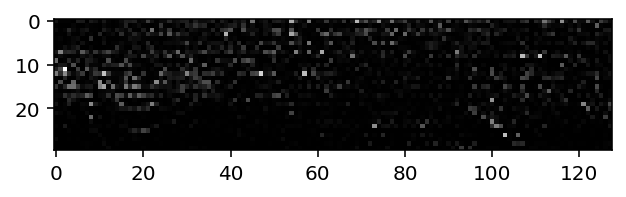

prediction_5.mid


Original
x_test_6.mid


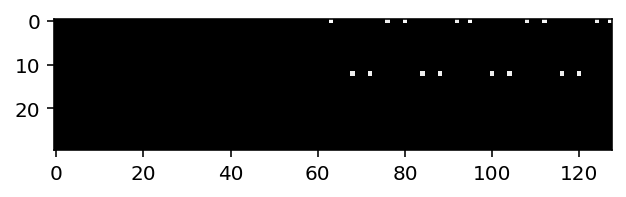

Reproduction


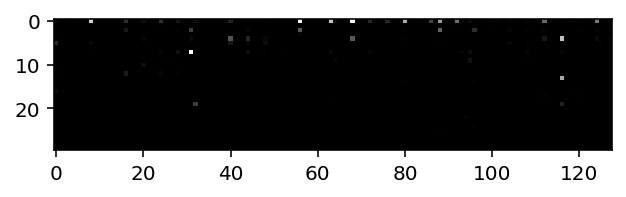

prediction_6.mid


Original
x_test_7.mid


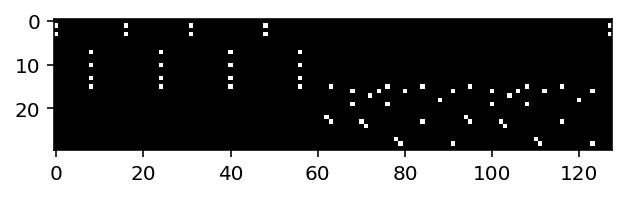

Reproduction


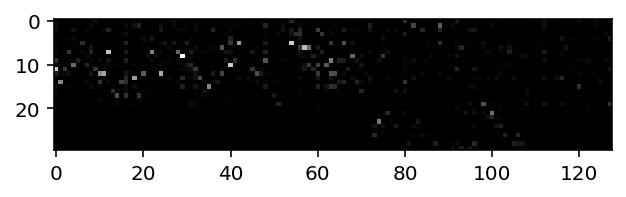

prediction_7.mid


Original
x_test_8.mid


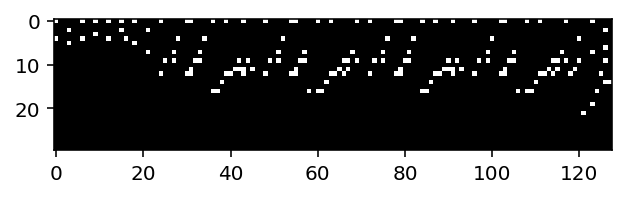

Reproduction


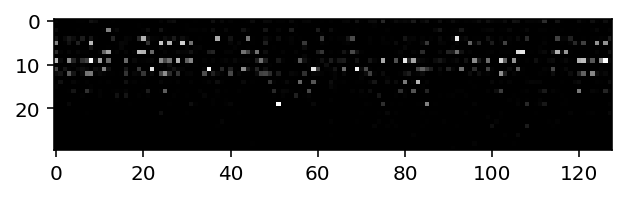

prediction_8.mid


Original
x_test_9.mid


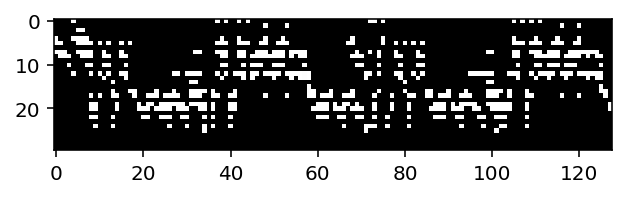

Reproduction


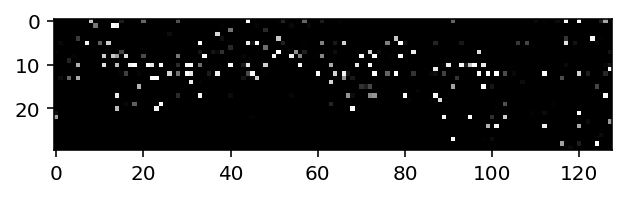

prediction_9.mid


Original
x_test_10.mid


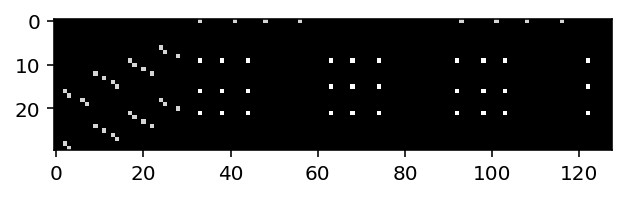

Reproduction


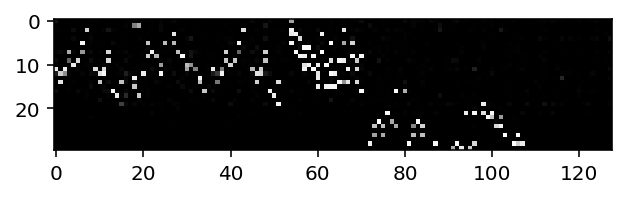

prediction_10.mid


Original
x_test_11.mid


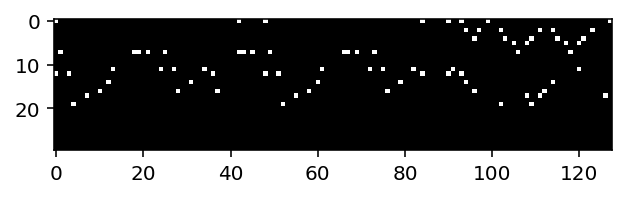

Reproduction


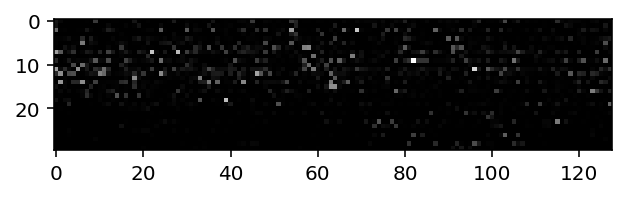

prediction_11.mid


Original
x_test_12.mid


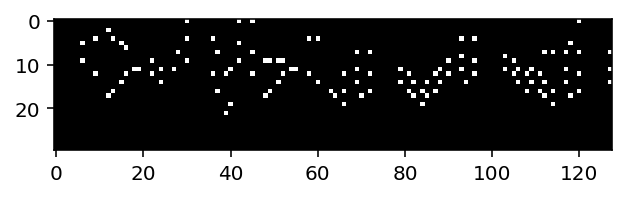

Reproduction


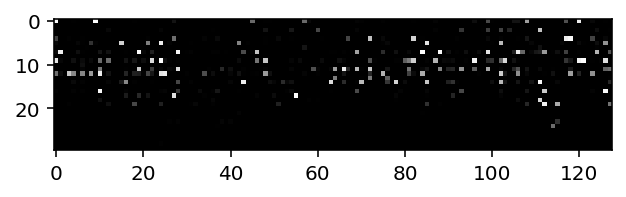

prediction_12.mid


Original
x_test_13.mid


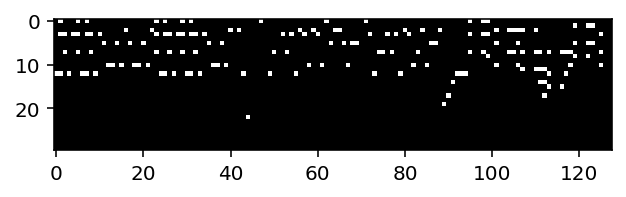

Reproduction


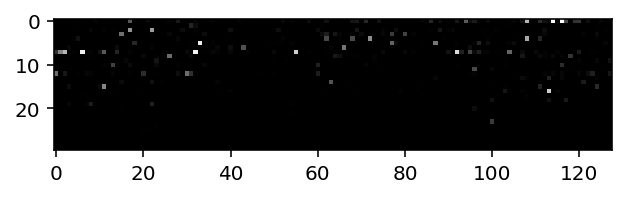

prediction_13.mid


Original
x_test_14.mid


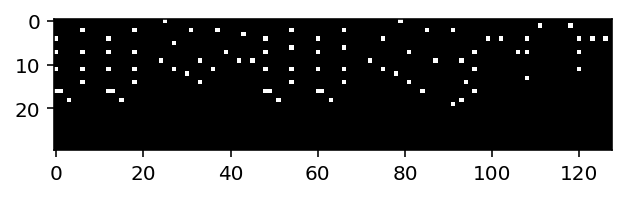

Reproduction


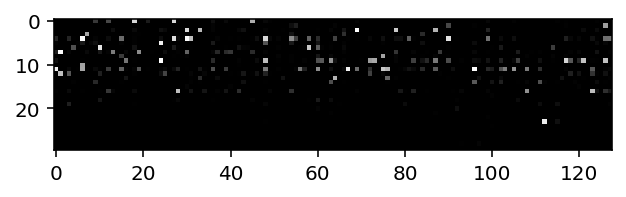

prediction_14.mid


Original
x_test_15.mid


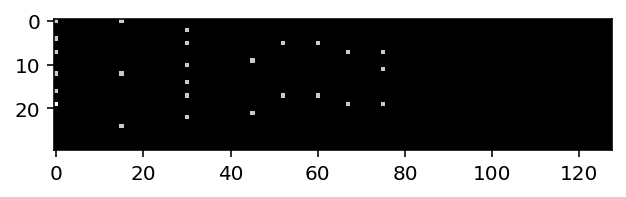

Reproduction


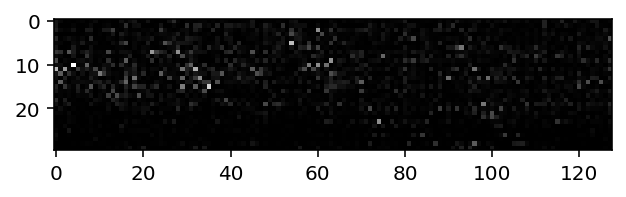

prediction_15.mid


Original
x_test_16.mid


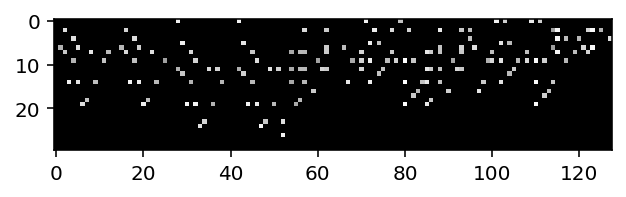

Reproduction


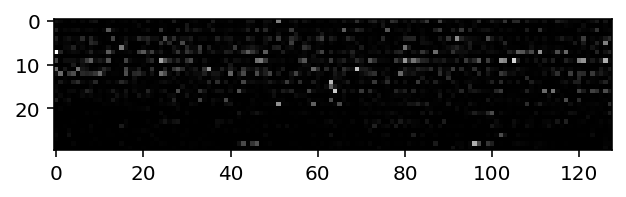

prediction_16.mid


Original
x_test_17.mid


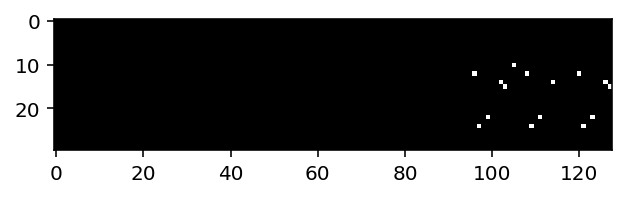

Reproduction


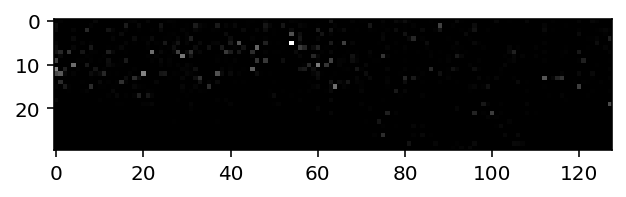

prediction_17.mid


Original
x_test_18.mid


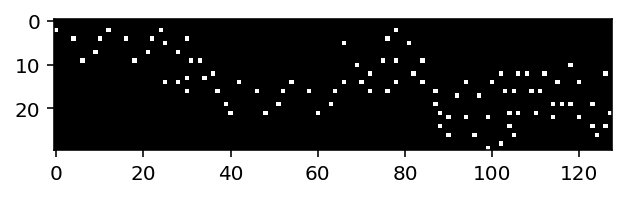

Reproduction


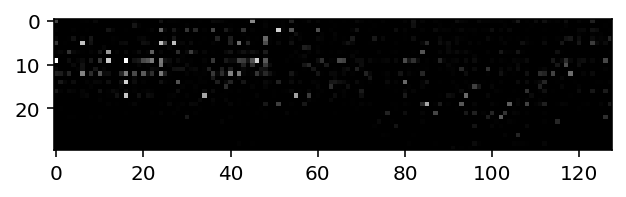

prediction_18.mid


Original
x_test_19.mid


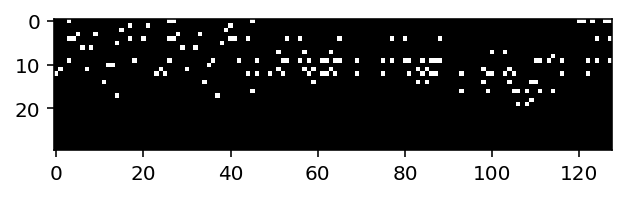

Reproduction


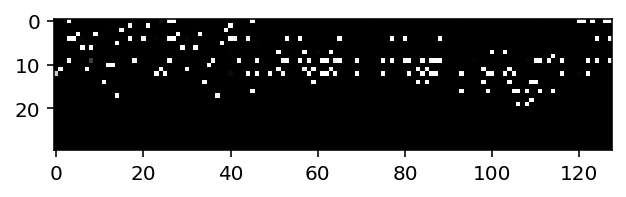

prediction_19.mid


Original
x_test_20.mid


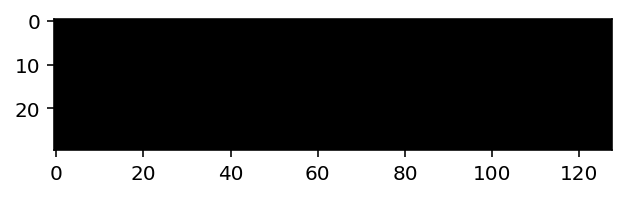

IndexError: list index out of range

In [20]:

# on new data using `predict`
print("Generate predictions for 3 samples")
print(x_test.shape)
predictions = vae.predict(x_test)
print("predictions shape:", predictions.shape)
#print("predictions:", predictions);
for i in range(len(predictions)):
    canvas_recon = np.empty((HEIGHT, WIDTH))
    
    #print("File ", result[i].as_posix())
    
    print("Original")
    print("x_test_" + str(i) + ".mid")
    generateTrackImage(x_test[i])
    
    pattern = generateTrack(x_test[i])
    filename = "x_test_" + str(i) + ".mid"
    midi.write_midifile(filename, pattern)
    s = converter.parse(filename)
    s.show('midi')
    
    print("Reproduction")
    generateTrackImage(predictions[i])
    
    pattern = generateTrack(predictions[i])
    print("prediction_" + str(i) + ".mid")
    filename = "prediction_" + str(i) + ".mid"
    midi.write_midifile(filename, pattern)
    s = converter.parse(filename)
    s.show('midi')

## Generate new data